In [1]:
import datetime
import pandas as pd
import random
import numpy as np
import seaborn as sns

# Set display format to avoid scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:

rng = np.random.default_rng(123)

start_year = 1950
end_year = 2050
portfolios = ["First", "Second", "Third", "Fourth", "Fifth"]
portfolios_list = []
dates_list = []


for portfolio in portfolios:
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            date = datetime.date(year, month, 1)
            dates_list.append(date)
            portfolios_list.append(portfolio)

random_returns = rng.uniform(low=0, high=(0.10 / 12), size=len(dates_list))


fake_returns = pd.DataFrame(
    {"Portfolio": portfolios_list, "date": dates_list, "ret": random_returns}
)


fake_returns['income'] = 0.0

In [3]:
fake_returns

,Portfolio,date,ret,income
0,First,1950-01-01,0.006,0.000
1,First,1950-02-01,0.000,0.000
2,First,1950-03-01,0.002,0.000
3,First,1950-04-01,0.002,0.000
4,First,1950-05-01,0.001,0.000
...,...,...,...,...
6055,Fifth,2050-08-01,0.007,0.000
6056,Fifth,2050-09-01,0.004,0.000
6057,Fifth,2050-10-01,0.006,0.000
6058,Fifth,2050-11-01,0.001,0.000


In [4]:
# Some pseudo code

# Input variables (these require input from the user, MANDATORY)

submitted_income = 85000
income_growth = 0.035

monthly_income = submitted_income/12
monthly_growth = 1+ (income_growth/12)

start_savings = 25
retirement_start = 65
death_year = 85

month_start_savings = start_savings*12
month_retirement_start = retirement_start*12
death_month = death_year*12



# I think I just want these to be static
save_rate = 0.10
consumption_rate = 0.04
inflation_rate = 0.02

In [5]:
total_monthly_incomes = []

for t in fake_returns.index[month_start_savings:month_retirement_start]:
    current_month = t-month_start_savings
    income_for_month = monthly_income*(monthly_growth**current_month)
    total_monthly_incomes.append(income_for_month)


In [6]:
# Apply mapping to DataFrame's index to create a month column that resets for each portfolio
fake_returns['month'] = fake_returns.groupby('Portfolio').cumcount()

# Map the total_monthly_incomes to each row based on the month
income_series = pd.Series(total_monthly_incomes, index=range(month_start_savings, month_retirement_start))
fake_returns['income'] = fake_returns['month'].map(income_series)
# set all nan values in income to 0.0
fake_returns['income'] = fake_returns['income'].fillna(0.0)


# Optional: Remove the month column if it's no longer needed
#fake_returns.drop(columns='month', inplace=True)


In [7]:

fake_returns['savings'] = 0.0

for portfolio in fake_returns['Portfolio'].unique():
    # Filter the DataFrame by portfolio
    portfolio_data = fake_returns[fake_returns['Portfolio'] == portfolio]
    
    # Initialize previous savings
    previous_savings = 0
    initial_consumption = 0
    current_consumption = 0
    
    # Iterate through each row in the portfolio data
    for index, row in portfolio_data.iterrows():
        if row['month'] == month_retirement_start:
            initial_consumption = (previous_savings * consumption_rate)/12
            current_savings = (previous_savings - initial_consumption) * (1 + row['ret'])
            fake_returns.at[index, 'savings'] = current_savings
        if row['income'] == 0.0 and row['month'] > month_retirement_start and row['month'] < death_month:
            current_consumption = initial_consumption * ((1+inflation_rate)**(row['month']-month_retirement_start))
            if previous_savings <= current_consumption:
                current_consumption = previous_savings
            current_savings = (previous_savings - current_consumption) * (1 + row['ret'])
            fake_returns.at[index, 'savings'] = current_savings
        elif row['month'] >= death_month:
            fake_returns.at[index, 'savings'] = previous_savings
        else:
            current_savings = save_rate * row['income'] + previous_savings * (1 + row['ret'])
            fake_returns.at[index, 'savings'] = current_savings
        # Update previous savings
        previous_savings = current_savings

In [8]:
fake_returns.iloc[month_start_savings:month_retirement_start]

,Portfolio,date,ret,income,month,savings
300,First,1975-01-01,0.002,7083.333,300,708.333
301,First,1975-02-01,0.005,7103.993,301,1422.001
302,First,1975-03-01,0.004,7124.713,302,2140.849
303,First,1975-04-01,0.004,7145.493,303,2863.101
304,First,1975-05-01,0.003,7166.334,304,3588.163
...,...,...,...,...,...,...
775,First,2014-08-01,0.003,28251.450,775,1855914.977
776,First,2014-09-01,0.007,28333.850,776,1872564.793
777,First,2014-10-01,0.008,28416.491,777,1891005.042
778,First,2014-11-01,0.007,28499.372,778,1907108.709


In [9]:
fake_returns.iloc[month_retirement_start:death_month]

,Portfolio,date,ret,income,month,savings
780,First,2015-01-01,0.000,0.000,780,1916397.567
781,First,2015-02-01,0.004,0.000,781,1917967.848
782,First,2015-03-01,0.004,0.000,782,1919094.930
783,First,2015-04-01,0.000,0.000,783,1912373.375
784,First,2015-05-01,0.007,0.000,784,1919253.387
...,...,...,...,...,...,...
1015,First,2034-08-01,0.004,0.000,1015,0.000
1016,First,2034-09-01,0.003,0.000,1016,0.000
1017,First,2034-10-01,0.004,0.000,1017,0.000
1018,First,2034-11-01,0.008,0.000,1018,0.000


In [10]:
print(fake_returns.query('Portfolio=="First"').to_string())

     Portfolio        date   ret    income  month     savings
0        First  1950-01-01 0.006     0.000      0       0.000
1        First  1950-02-01 0.000     0.000      1       0.000
2        First  1950-03-01 0.002     0.000      2       0.000
3        First  1950-04-01 0.002     0.000      3       0.000
4        First  1950-05-01 0.001     0.000      4       0.000
5        First  1950-06-01 0.007     0.000      5       0.000
6        First  1950-07-01 0.008     0.000      6       0.000
7        First  1950-08-01 0.002     0.000      7       0.000
8        First  1950-09-01 0.007     0.000      8       0.000
9        First  1950-10-01 0.007     0.000      9       0.000
10       First  1950-11-01 0.004     0.000     10       0.000
11       First  1950-12-01 0.002     0.000     11       0.000
12       First  1951-01-01 0.007     0.000     12       0.000
13       First  1951-02-01 0.002     0.000     13       0.000
14       First  1951-03-01 0.006     0.000     14       0.000
15      

c:\Users\justi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\justi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='date', ylabel='savings'>

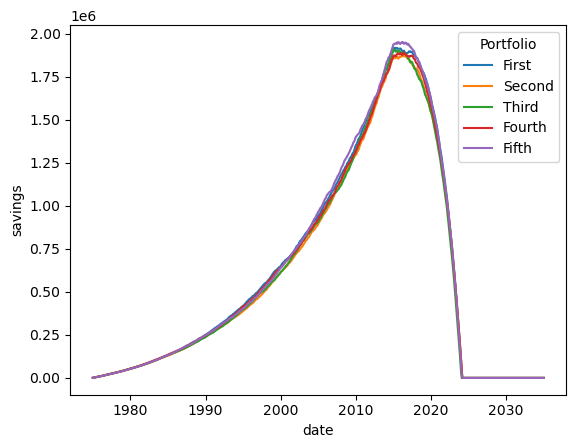

In [11]:
# make an sns lineplot showing the savings over time for each portfolio
# only include entries whose months fall between month_start_savings and death_month
fake_returns = fake_returns[(fake_returns['month'] >= month_start_savings) & (fake_returns['month'] <= death_month)]

sns.lineplot(data=fake_returns, x='date', y='savings', hue='Portfolio')